# **Problem Statement**

In the competitive landscape of financial services, offering personalized products and services is essential for attracting and retaining customers. CreditX, a leading financial organization, recognizes the importance of aligning its offerings with the unique financial behaviors and lifestyles of its customers.

The organization plans to employ a dual approach to accomplish this aim:

- For existing customers, they want to analyze their credit history and spending patterns across various categories, such as travel, fuel, groceries, shopping, dining, utilities, and entertainment. These insights enable CreditX to understand their preferences and financial habits, allowing for personalized recommendations that resonate with their lifestyles.

- For new customers who lack historical data, CreditX plans to take a proactive approach by collecting essential information through targeted questions. These inquiries focus on aspects such as lifestyle choices, spending tendencies, income levels, and property ownership.

By integrating insights from both existing and new customers, CreditX can provide accurate and relevant credit card recommendations tailored to meet individual needs, allowing them to not only enhance customer satisfaction but also strengthen its position in the market.

# **Dataset**

This dataset for the use case at hand is a database containing two tables:

1. **Credit Card Information Table (`credit_cards`)**: Contains the details of the credit cards offered by the organization

2. **Customer Information Table (`customers`)**: Contains demographic, credit, and spending attributes of the current customers of the organization

### **`credit_cards`**

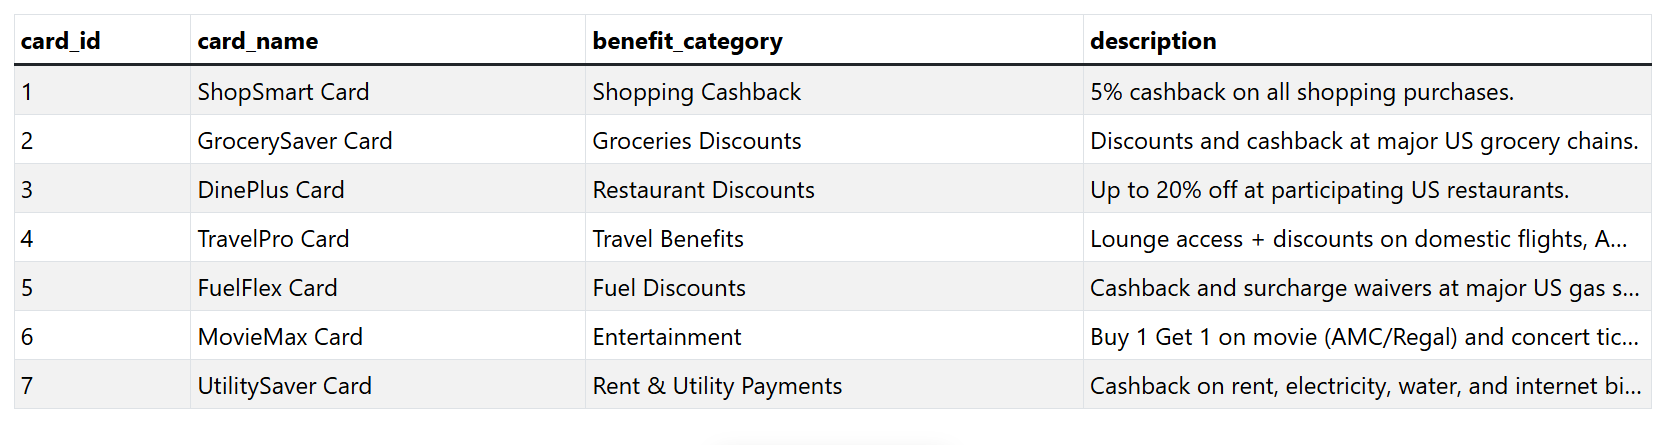

- **card_id**: Unique identifier for each credit card.

- **card_name**: Name of the credit card product.

- **benefit_category**: Primary rewards category of the card.

- **description**: Summary description of the card's benefits.

### **`customers`**

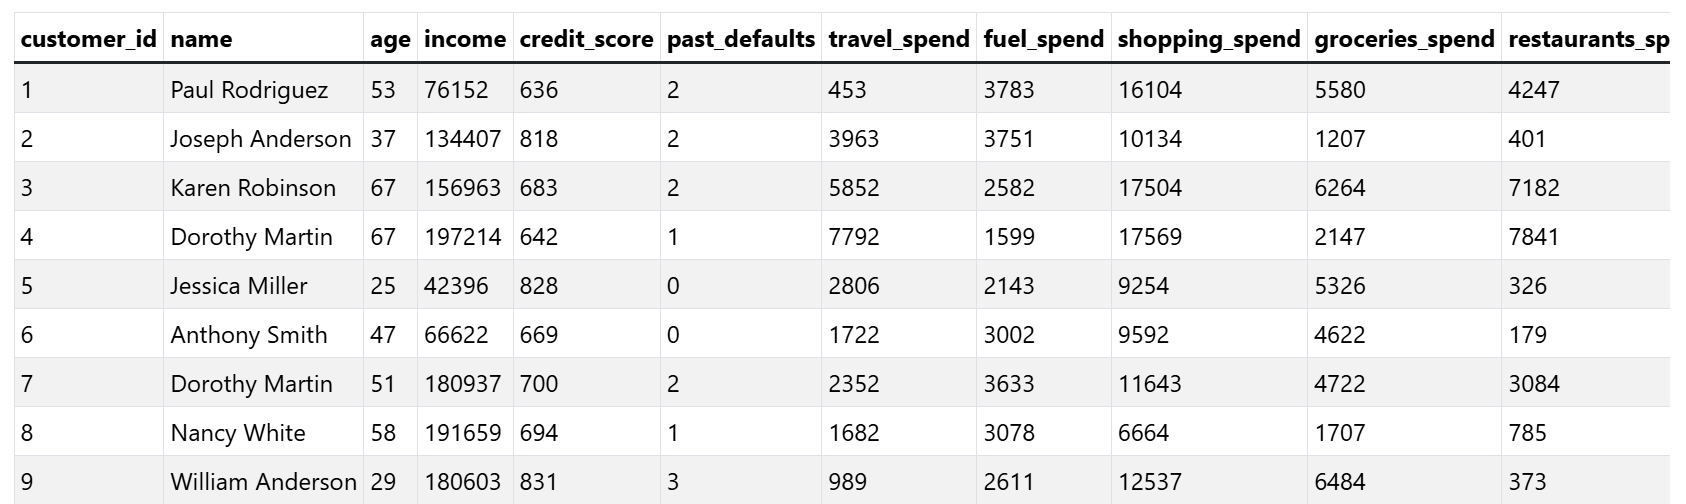

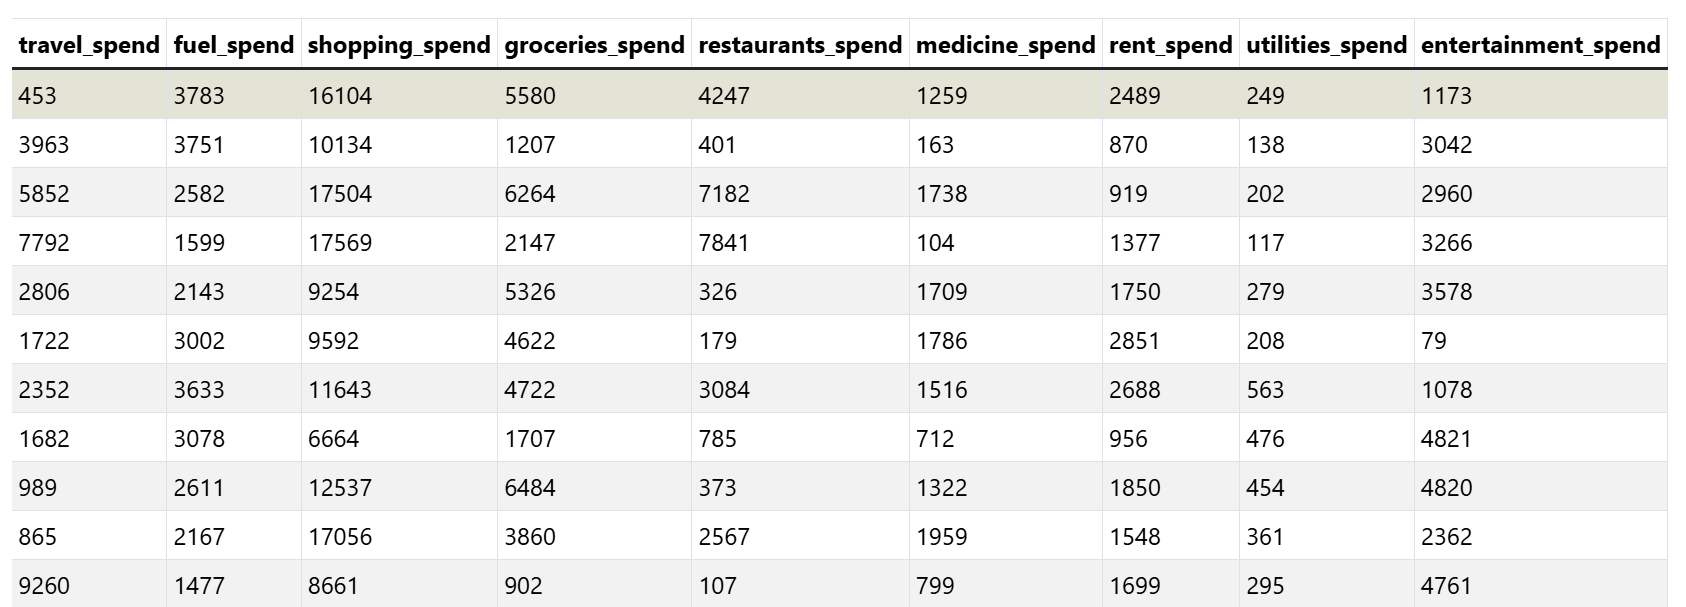

- **customer_id**: Unique identifier for each customer.

- **name**: The customer's full name.

- **age**: Customer's age in years.

- **income**: Annual income of the customer.

- **credit_score**: Customer's current credit score.

- **past_defaults**: Number of past loan or credit defaults.

- **travel_spend**: Monthly spending on travel.

- **fuel_spend**: Monthly spending on fuel.

- **shopping_spend**: Monthly spending on shopping.

- **groceries_spend**: Monthly spending on groceries.

- **restaurants_spend**: Monthly spending on dining out.

- **medicine_spend**: Monthly spending on healthcare and medicines.

- **rent_spend**: Monthly spending on rent or housing.

- **utilities_spend**: Monthly spending on bills and utilities.

- **entertainment_spend**: Monthly spending on entertainment.


# **Setup**

## Installing Necessary Libraries

In [31]:
!pip install -q langchain-openai langchain-community

In [32]:
import json
import os
import sqlite3
from typing import Any, List, Optional, Dict

# from langgraph.prebuilt import create_react_agent
# from langchain.agents import create_agent
# from langchain.tools import tool

from langchain_openai import ChatOpenAI
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langsmith import traceable

## Setting up the LLM

We set up the LLM environment variables so the agent can securely authenticate with the OpenAI API and know where to send requests. This ensures every downstream step such as loading models, invoking tools, and running the agent happens smoothly without hard-coding sensitive credentials in the code.

In [33]:
file_name = 'config.json'
with open(file_name, 'r') as file:
    config = json.load(file)

# Set environment variable for OpenAI (recommended)
os.environ["OPENAI_API_KEY"] = config["OPENAI_API_KEY"]
os.environ["OPENAI_API_BASE"] = config["OPENAI_API_BASE"]

In [34]:
# setting up the LLM
llm = ChatOpenAI(
    model="gpt-4o",    # Specifies which OpenAI model the agent will use
    api_key=os.environ["OPENAI_API_KEY"],    # Authenticates securely using the API key stored in environment variables
    base_url = os.environ["OPENAI_API_BASE"],    # Points the client to the correct OpenAI (or proxy) endpoint
    temperature=0.0,   # Ensures deterministic, consistent responses by reducing randomness
)

# **Single Agent System**

In this section, we'll build a simple AI agent that recommends a credit card to a customer using the context provided in its prompt.

We're going to illustrate the cases where the customer is and isn't part of the historical data available. We're going to break the illustration into two different scenarios.
- Scenario 1
    - Customer Info Available in Historical Data: Pass the relevant context directly in the prompt
    - Customer Info Not Available in Historical Data: Ask 3-4 clarifying questions to understand their profile
- Scenario 2
    - Customer Info Available in Historical Data: Load info from the database tables and pass the entire info for relevant context in the prompt
    - Customer Info Not Available in Historical Data: Ask 3-4 clarifying questions to understand their profile

In both cases, the idea is to get to understand the customer before suggesting a suitable credit card.

## Scenario 1

We will build a single agent system where a summary of the credit and spending attributes of a random customer is passed as part of the prompt.

In [35]:
# --- Agent Function ---
def creditx_agent(user_message, customer_has_history=False):
    """
    A simple single-LLM agent:
    - If customer has credit history, analyze spending & recommend a card
    - If not, ask relevant questions
    """

    system_prompt = """
    You are CreditX's credit card recommendation assistant.
    Your job is to understand the customer's needs and guide them.
    If the customer is new and no historical data is available,
    ask relevant questions about lifestyle, spending, income,
    and property. Keep replies short and friendly.
    """

    if customer_has_history:
        # You would normally fetch history from DB — here we simulate it
        history_summary = """
        The customer spends heavily on travel and restaurants, moderately on groceries, and rarely on fuel or utilities.
        Credit score is good (760+).
        """
        user_message = (
            f"The customer said: '{user_message}'. "
            f"Here is the historical data: {history_summary}. "
            f"Recommend a suitable credit card based on this."
        )
    else:
        # New customer: ask questions instead of recommending immediately
        user_message = (
            f"The customer said: '{user_message}'. "
            "The customer is new. Ask 3–4 questions needed to assess lifestyle, spending behavior, income, and property."
        )

    response = llm.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_message}
        ]
    )

    return response.content

### Test Case 1: Customer History Present in the Prompt

This test case is designed to verify whether the Agent can recommend credit cards based on the user's history, which is passed in the prompt.

In [36]:
user_query_1 = "Hi, I am Paul and I want a new credit card. What are the options available"
agent_response_1 = creditx_agent(user_query_1, customer_has_history=True)

print("User Query:")
print(user_query_1)
print("\n----------\n")
print("Agent Response:")
agent_response_1

User Query:
Hi, I am Paul and I want a new credit card. What are the options available

----------

Agent Response:


"Hi Paul! Based on your spending habits and good credit score, I'd recommend a travel rewards credit card. These cards often offer great points or miles for travel and dining expenses. You might also enjoy perks like airport lounge access or travel insurance. Would you like more details on specific cards?"

> <font size=4>**Note**: Due to the probabilistic nature of the LLM powering the AI Agent, the output might vary slightly with each run.</font>

### Test Case 2: Customer History Absent in the Prompt

This test case is designed to verify whether the Agent can ask relevant questions to a new customer, as we don't have their credit or spending history.

In [37]:
user_query_2 = "Hi, I am Paul and I want a new credit card. What are the options available"
agent_response_2 = creditx_agent(user_query_2, customer_has_history=False)

print("User Query:")
print(user_query_2)
print("\n----------\n")
print("Agent Response:")
print(agent_response_2)


User Query:
Hi, I am Paul and I want a new credit card. What are the options available

----------

Agent Response:
Hi Paul! Great to hear you're interested in a new credit card. To help find the best option for you, could you tell me:

1. What are your main spending categories? (e.g., travel, dining, groceries)
2. Do you have a monthly income range you can share?
3. Are you looking for any specific card benefits, like cashback or travel rewards?
4. Do you own any property or have any significant financial commitments? 

This will help us tailor the best recommendations for you!


## Scenario 2

Since we have multiple customers, we need to pass their information to the Agent so that it can provide better recommendations.

We'll build a single-agent system wherein we'll pass the details of all customers and credit cards from the database as a part of the prompt.

In [38]:
# --- Agent Function ---
def creditx_agent_add_tables_in_prompt(user_message, customer_has_history=False, db_path="credits.db"):
    """
    Enhanced agent using llm.invoke:
    - Loads DB tables and injects them into the system prompt.
    - If the user has history: include spending/credit details.
    - If new: ask questions.
    """

    # --- 1. Load DB tables ---
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Load full customer table
    cursor.execute("SELECT * FROM customers")
    customers_data = cursor.fetchall()


    # Load credit card table
    cursor.execute("SELECT * FROM credit_cards")
    cards_data = cursor.fetchall()

    conn.close()


    # --- 2. Build the system prompt (with DB injected!) ---
    system_prompt = f"""
    You are CreditX's intelligent credit card recommendation assistant!

    Below is the full **Customer Database**:
    {customers_data}

    Below is the complete **Credit Card Catalog**:
    {cards_data}

    Your job:
    - Understand the customer's needs
    - Refer to the supplied DB data in your reasoning
    - If the customer is NEW, ask 3–4 short questions about lifestyle, spending, income, and property
    - Keep responses brief, helpful, and friendly
    """

    final_user_msg = (
            f"The customer said: '{user_message}'. "
            "If this is a new customer. Ask 3-4 questions needed to assess "
            "lifestyle, spending behavior, income, and property."
            "Otherwise if this is a known customer, then recommend him a credit card based on his past spending and credit history"
            "Don't recommnend a credit card if credit score is below 750."
            "If customer has defaulted 2 times then don't recommend a credit card."
        )

    # --- 4. Call the LLM using llm.invoke ---
    response = llm.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": final_user_msg}
        ]
    )

    return response.content

### Test Case 1: Customer History present in Database Tables



This test case checks how the single agent fetches customer details from the data fed into the prompt itself and how it doesn't recommend any card because the customer falls short of the prerequisites for a credit card due to a low credit score.

In [39]:
user_query_1 = "Hi, I am Thomas Taylor and I want a new credit card. What are the options available"
agent_response_1 = creditx_agent_add_tables_in_prompt(user_query_1)

print("User Query:")
print(user_query_1)
print("\n----------\n")
print("Agent Response:")
print(agent_response_1)

User Query:
Hi, I am Thomas Taylor and I want a new credit card. What are the options available

----------

Agent Response:
Hello Thomas Taylor! I see you're already in our database. Let's take a look at your profile:

- Age: 48
- Income: $234,815
- Credit Score: 618
- Defaults: 1
- Spending Patterns: 
  - Shopping: $6,978
  - Groceries: $3,792
  - Dining: $12,465
  - Travel: $5,543
  - Fuel: $2,490
  - Entertainment: $700
  - Utilities: $1,262

Unfortunately, your current credit score is below 750, so I can't recommend a credit card at this time. Improving your credit score could open up more options for you in the future. If you have any questions or need advice on improving your credit score, feel free to ask!


### Test Case 2: Customer History present in Database Tables

This test case checks how the single agent fetches customer details from the data fed into the prompt itself and how it doesn't recommend any card because the customer falls short of the prerequisites for a credit card due to a low credit score and multiple defaults.

In [40]:
user_query_2 = "Hi, I am Paul Rodriguez and I want a new credit card. What are the options available"
agent_response_2 = creditx_agent_add_tables_in_prompt(user_query_2)

print("User Query:")
print(user_query_2)
print("\n----------\n")
print("Agent Response:")
print(agent_response_2)

User Query:
Hi, I am Paul Rodriguez and I want a new credit card. What are the options available

----------

Agent Response:
Hello Paul Rodriguez! I see you're already in our system. Let's take a look at your profile:

- Age: 53
- Income: $76,152
- Credit Score: 636
- Defaults: 2
- Spending Patterns: Significant spending on utilities and groceries

Given your current credit score of 636 and the fact that there have been 2 defaults, I would advise focusing on improving your credit score before applying for a new credit card. Once your score is above 750, we can explore options that best suit your spending habits and lifestyle. If you have any questions or need advice on improving your credit score, feel free to ask!


## Limitations and Remedies

**Limitations of a Single Agent System**

* Performs well only when all required data fits inside a static prompt.
* Struggles with tasks involving dynamic, frequently changing, or large datasets.
* Cannot execute deterministic logic or structured operations reliably within the prompt alone.
* Suffers from strict context-window limits, making it impossible to load full tables, long histories, or evolving records at scale.
* Risks inaccuracies or hallucinations when forced to 'infer' data instead of fetching it.

**How Tools Overcome These Limitations**

* Provide controlled access to databases, APIs, and computations, letting the agent pull only the precise data it needs.
* Enable deterministic, accurate logic execution (queries, calculations, validations) outside the LLM's text-only reasoning.
* Reduce context load by retrieving information on demand instead of stuffing it into the prompt.
* Allow scalable, production-ready workflows where the model becomes action-capable rather than context-bound.
* Improve reliability, consistency, and task performance across both known and new customer scenarios.


